In [82]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [83]:
L = 1.0  # Total length of rod
A = 0.2  # Cross sectional area of rod
E = 10   # Elastic modulus of rod
q_0 = 5.0*A   # Downward force per unit length of rod

In [84]:
M = 2  # Number of elements
N = M+1  # Number of nodes

In [85]:
# Define the connectivity matrix
nodes = np.linspace(0,L,N)
connectivity = np.array([ [i,i+1] for i in range(M)],dtype=int)
connectivity

array([[0, 1],
       [1, 2]])

In [86]:
# Define the element matrices
k_elements = []
f_elements = []
for current_elem in range(M):
    node1 = nodes[connectivity[current_elem,0]]
    node2 = nodes[connectivity[current_elem,1]]
    elem_length = node2-node1
    k_elements.append( E*A*np.array([[1/elem_length, -1/elem_length],[-1/elem_length, 1/elem_length]]) )
    
    f_elements.append( q_0*np.array([elem_length/2.0, elem_length/2.0]) )
    

In [87]:
# Assemble the matrices
K = np.zeros((N,N))
F = np.zeros((N,1))

for elem_num,elem_k in enumerate(k_elements):
    for i in range(2):
        row = connectivity[elem_num,i]
        F[row] += f_elements[elem_num][i]
        for j in range(2):
            col = connectivity[elem_num,j]
            K[row,col] += elem_k[i,j]
            
            
        
(K,F)
    

(array([[ 4., -4.,  0.],
        [-4.,  8., -4.],
        [ 0., -4.,  4.]]),
 array([[0.25],
        [0.5 ],
        [0.25]]))

In [88]:
# Partition the matrices
A_sub = K[0:1,0:1]
B = K[0:1, 1:N]
C = K[1:N,0:1]
D = K[1:N, 1:N]
beta = np.array([[0]])
F = F[1:N]

In [89]:
delta = np.linalg.inv(D)@(F-C@beta)
delta
all_deltas = np.reshape(np.vstack( (beta,delta) ), (-1))
all_deltas

array([0.    , 0.1875, 0.25  ])

In [90]:
R = A_sub@beta + B@delta
R

array([[-0.75]])

In [91]:
element_stress = []

for node1,node2 in connectivity:
    elongation = (all_deltas[node2]-all_deltas[node1])/(nodes[node2]-nodes[node1])
    element_stress.append(E*elongation)

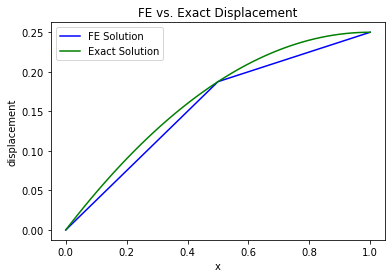

In [92]:
# Displacement plot
plt.plot(nodes,all_deltas,'b',label='FE Solution')
plt.xlabel('x')
plt.ylabel('displacement')
plt.title('FE vs. Exact Displacement')
x_values = np.linspace(0,L)
plt.plot(x_values,np.reshape( (1/(A*E)) * (-((q_0*(x_values**2))/2.0) + q_0*L*x_values) ,(-1)), 'g', label='Exact Solution')
plt.legend(loc='best')


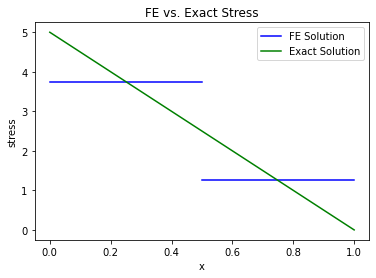

In [93]:
# Stress plot
for (elem_num, (node1,node2)) in enumerate(connectivity):
    if elem_num == 0:
        plt.plot([nodes[node1],nodes[node2]], [element_stress[elem_num], element_stress[elem_num]],'b',label='FE Solution')
    else:
        plt.plot([nodes[node1],nodes[node2]], [element_stress[elem_num], element_stress[elem_num]],'b')

plt.plot(x_values,np.reshape(((q_0*L)/(A))*(1-x_values/L),(-1)),'g', label='Exact Solution')

plt.xlabel('x')
plt.ylabel('stress')
plt.title('FE vs. Exact Stress')
plt.legend(loc='best')